In [166]:
import pandas as pd
from textblob import TextBlob

# 初始化一个空的DataFrame来聚合结果
aggregated_scores = pd.DataFrame()

# 读取CSV文件并选择所需的列
df = pd.read_csv('data/Bitcoin_tweets.csv', usecols=['date', 'text', 'is_retweet', 'user_followers', 'user_friends', 'user_favourites'], lineterminator='\n')

# 将日期列转换为日期格式
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 只保留日期部分
df['date'] = df['date'].dt.date

# 删除任何转换失败的行
df = df.dropna(subset=['date'])

# 过滤出2022年的数据
df = df[df['date'].apply(lambda x: x.year == 2022)]

# 显示前几行数据
df.head()

C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_68976\1545163833.py:8: DtypeWarning: Columns (4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Bitcoin_tweets.csv', usecols=['date', 'text', 'is_retweet', 'user_followers', 'user_friends', 'user_favourites'], lineterminator='\n')


,user_followers,user_friends,user_favourites,date,text,is_retweet
1999534,511.0,413.0,19592.0,2022-01-14,Death Cross #bitcoin dump? https://t.co/UPjFVs...,False
1999535,26.0,557.0,12098.0,2022-01-14,#bitcoin is revolutionizing the insurance indu...,False
1999536,94.0,302.0,399.0,2022-01-14,Teaser! #Bitcoin #cryptocurrency #furniture ht...,False
1999537,51.0,284.0,316.0,2022-01-14,I am claiming my free Lightning sats from @_bi...,False
1999538,235.0,924.0,3623.0,2022-01-14,"@mentalist420 Hey, Please check out my hand dr...",False


In [167]:
# 转换user_favourites, user_friends, user_followers列为数值型数据，并处理转换错误
df['user_favourites'] = pd.to_numeric(df['user_favourites'], errors='coerce')
df['user_friends'] = pd.to_numeric(df['user_friends'], errors='coerce')
df['user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce')

# 删除转换失败的行
#df = df.dropna(subset=['user_favourites', 'user_friends', 'user_followers'])

#df=df[(df['is_retweet']==False)&(df['user_favourites']>df['user_followers'])&(df['user_friends']*10<df['user_followers'])]
df.head()

,user_followers,user_friends,user_favourites,date,text,is_retweet
1999534,511.0,413.0,19592.0,2022-01-14,Death Cross #bitcoin dump? https://t.co/UPjFVs...,False
1999535,26.0,557.0,12098.0,2022-01-14,#bitcoin is revolutionizing the insurance indu...,False
1999536,94.0,302.0,399.0,2022-01-14,Teaser! #Bitcoin #cryptocurrency #furniture ht...,False
1999537,51.0,284.0,316.0,2022-01-14,I am claiming my free Lightning sats from @_bi...,False
1999538,235.0,924.0,3623.0,2022-01-14,"@mentalist420 Hey, Please check out my hand dr...",False


In [168]:
df.shape[0]

2628878

In [169]:
# 按照日期排序，然后按照followers和favourites排序
df = df.sort_values(by=['date', 'user_followers', 'user_favourites'], ascending=[True, False, False])

# 分组并取每天前50条
df = df.groupby('date').head(15)

# 显示前几行数据
df

,user_followers,user_friends,user_favourites,date,text,is_retweet
2110064,2581302.0,1462.0,5433.0,2022-01-11,The impact of the @federalreserve's December m...,False
2115663,2252536.0,922.0,10079.0,2022-01-11,On the topic of powering #Bitcoin City with #g...,False
2120723,1953922.0,665.0,21154.0,2022-01-11,"The SEC is ""running out of excuses"" for reject...",False
2118135,1953912.0,665.0,21154.0,2022-01-11,@real_bill_gross Join Bitcoin Magazine's daily...,False
2117852,1953911.0,665.0,21154.0,2022-01-11,BREAKING – Strike officially launches #Bitcoin...,False
...,...,...,...,...,...,...
4590702,1261957.0,696.0,15034.0,2022-12-27,#Bitcoin is taking a dump right now… 💩,False
4589028,1261956.0,696.0,15034.0,2022-12-27,"I think #Bitcoin will break above $20,000 in t...",False
4594490,1204265.0,2728.0,42558.0,2022-12-27,https://t.co/8kWqgEeplL Crypto Loan\n\n📣 #USDT...,False
4589523,1182010.0,630.0,149311.0,2022-12-27,Traditional finance has built fiat on-ramps to...,False


In [170]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


[nltk_data] Downloading package stopwords to C:\Users\ALLEN
[nltk_data]     AN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [172]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext


100%|██████████| 1755/1755 [00:03<00:00, 449.22it/s]


In [173]:
df.head()

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleantext
2110064,2581302.0,1462.0,5433.0,2022-01-11,The impact of the @federalreserve's December m...,False,"[impact, federalreserv, decemb, meet, sent, co..."
2115663,2252536.0,922.0,10079.0,2022-01-11,On the topic of powering #Bitcoin City with #g...,False,"[topic, power, bitcoin, citi, geotherm, energi..."
2120723,1953922.0,665.0,21154.0,2022-01-11,"The SEC is ""running out of excuses"" for reject...",False,"[sec, run, excus, reject, spot, bitcoin, etf, ..."
2118135,1953912.0,665.0,21154.0,2022-01-11,@real_bill_gross Join Bitcoin Magazine's daily...,False,"[real, bill, gross, join, bitcoin, magazin, da..."
2117852,1953911.0,665.0,21154.0,2022-01-11,BREAKING – Strike officially launches #Bitcoin...,False,"[break, strike, offici, launch, bitcoin, light..."


In [174]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [175]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [176]:
df2 = compute_vader_scores(df,'cleantext')
df2

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
2110064,2581302.0,1462.0,5433.0,2022-01-11,The impact of the @federalreserve's December m...,False,"[impact, federalreserv, decemb, meet, sent, co...",0.000,0.898,0.102,0.3612,impact federalreserv decemb meet sent correl b...
2115663,2252536.0,922.0,10079.0,2022-01-11,On the topic of powering #Bitcoin City with #g...,False,"[topic, power, bitcoin, citi, geotherm, energi...",0.000,0.819,0.181,0.4939,topic power bitcoin citi geotherm energi bukel...
2120723,1953922.0,665.0,21154.0,2022-01-11,"The SEC is ""running out of excuses"" for reject...",False,"[sec, run, excus, reject, spot, bitcoin, etf, ...",0.148,0.714,0.137,-0.0516,sec run excus reject spot bitcoin etf 260 bill...
2118135,1953912.0,665.0,21154.0,2022-01-11,@real_bill_gross Join Bitcoin Magazine's daily...,False,"[real, bill, gross, join, bitcoin, magazin, da...",0.110,0.813,0.078,-0.2263,real bill gross join bitcoin magazin daili new...
2117852,1953911.0,665.0,21154.0,2022-01-11,BREAKING – Strike officially launches #Bitcoin...,False,"[break, strike, offici, launch, bitcoin, light...",0.075,0.850,0.075,0.0000,break strike offici launch bitcoin lightn serv...
...,...,...,...,...,...,...,...,...,...,...,...,...
4590702,1261957.0,696.0,15034.0,2022-12-27,#Bitcoin is taking a dump right now… 💩,False,"[bitcoin, take, dump, right]",0.464,0.536,0.000,-0.3818,bitcoin take dump right
4589028,1261956.0,696.0,15034.0,2022-12-27,"I think #Bitcoin will break above $20,000 in t...",False,"[think, bitcoin, break, 20, 000, next, 2, week]",0.000,1.000,0.000,0.0000,think bitcoin break 20 000 next 2 week
4594490,1204265.0,2728.0,42558.0,2022-12-27,https://t.co/8kWqgEeplL Crypto Loan\n\n📣 #USDT...,False,"[http, co, 8kwqgeepll, crypto, loan, usdt, btc...",0.000,0.892,0.108,0.4404,http co 8kwqgeepll crypto loan usdt btc eth ak...
4589523,1182010.0,630.0,149311.0,2022-12-27,Traditional finance has built fiat on-ramps to...,False,"[tradit, financ, built, fiat, ramp, bitcoin, g...",0.072,0.872,0.056,-0.0772,tradit financ built fiat ramp bitcoin grid nex...


In [177]:
# # 按照日期排序，然后按照followers和favourites排序
# df2 = df2.sort_values(by=['date', 'user_followers', 'user_favourites'], ascending=[True, False, False])
# 
# # 分组并取每天前50条
# top_50_per_day = df2.groupby('date').head(30)
# 
# # 显示前几行数据
# top_50_per_day

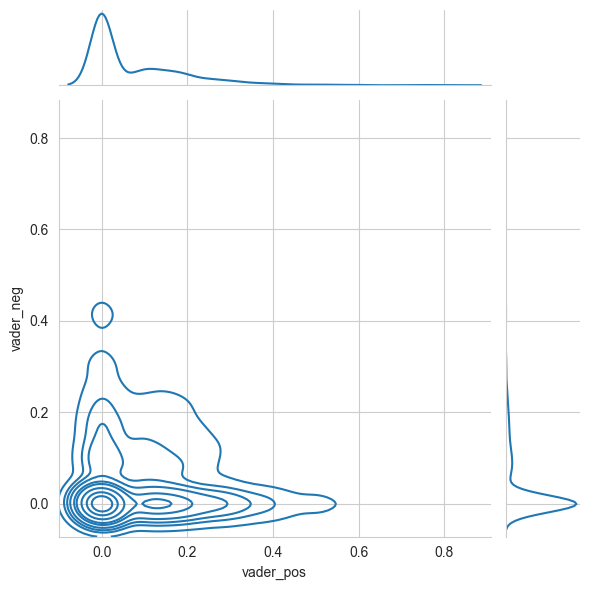

In [178]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

In [179]:
df2

,user_followers,user_friends,user_favourites,date,text,is_retweet,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
2110064,2581302.0,1462.0,5433.0,2022-01-11,The impact of the @federalreserve's December m...,False,"[impact, federalreserv, decemb, meet, sent, co...",0.000,0.898,0.102,0.3612,impact federalreserv decemb meet sent correl b...
2115663,2252536.0,922.0,10079.0,2022-01-11,On the topic of powering #Bitcoin City with #g...,False,"[topic, power, bitcoin, citi, geotherm, energi...",0.000,0.819,0.181,0.4939,topic power bitcoin citi geotherm energi bukel...
2120723,1953922.0,665.0,21154.0,2022-01-11,"The SEC is ""running out of excuses"" for reject...",False,"[sec, run, excus, reject, spot, bitcoin, etf, ...",0.148,0.714,0.137,-0.0516,sec run excus reject spot bitcoin etf 260 bill...
2118135,1953912.0,665.0,21154.0,2022-01-11,@real_bill_gross Join Bitcoin Magazine's daily...,False,"[real, bill, gross, join, bitcoin, magazin, da...",0.110,0.813,0.078,-0.2263,real bill gross join bitcoin magazin daili new...
2117852,1953911.0,665.0,21154.0,2022-01-11,BREAKING – Strike officially launches #Bitcoin...,False,"[break, strike, offici, launch, bitcoin, light...",0.075,0.850,0.075,0.0000,break strike offici launch bitcoin lightn serv...
...,...,...,...,...,...,...,...,...,...,...,...,...
4590702,1261957.0,696.0,15034.0,2022-12-27,#Bitcoin is taking a dump right now… 💩,False,"[bitcoin, take, dump, right]",0.464,0.536,0.000,-0.3818,bitcoin take dump right
4589028,1261956.0,696.0,15034.0,2022-12-27,"I think #Bitcoin will break above $20,000 in t...",False,"[think, bitcoin, break, 20, 000, next, 2, week]",0.000,1.000,0.000,0.0000,think bitcoin break 20 000 next 2 week
4594490,1204265.0,2728.0,42558.0,2022-12-27,https://t.co/8kWqgEeplL Crypto Loan\n\n📣 #USDT...,False,"[http, co, 8kwqgeepll, crypto, loan, usdt, btc...",0.000,0.892,0.108,0.4404,http co 8kwqgeepll crypto loan usdt btc eth ak...
4589523,1182010.0,630.0,149311.0,2022-12-27,Traditional finance has built fiat on-ramps to...,False,"[tradit, financ, built, fiat, ramp, bitcoin, g...",0.072,0.872,0.056,-0.0772,tradit financ built fiat ramp bitcoin grid nex...


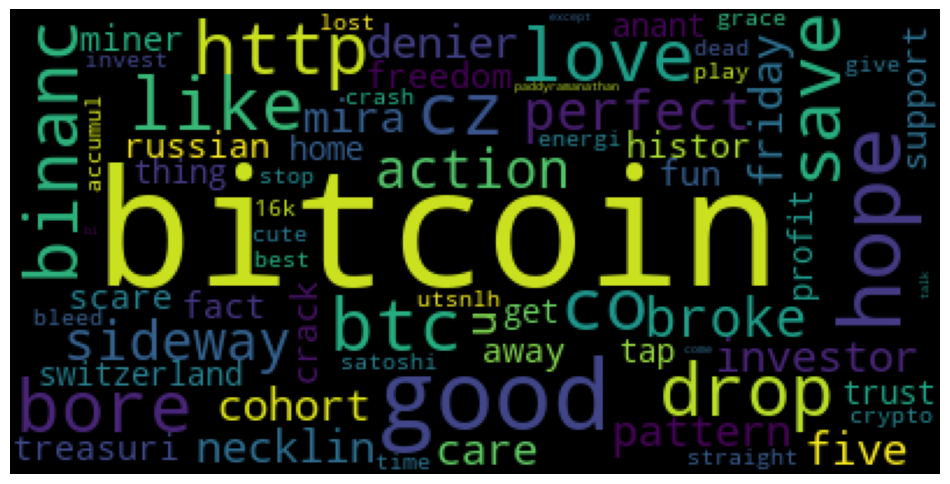

In [180]:
from wordcloud import WordCloud

vaderNeu05=df2[df2['vader_neu']<=0.5]


text = vaderNeu05['cleantext'].to_string().lower()  
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

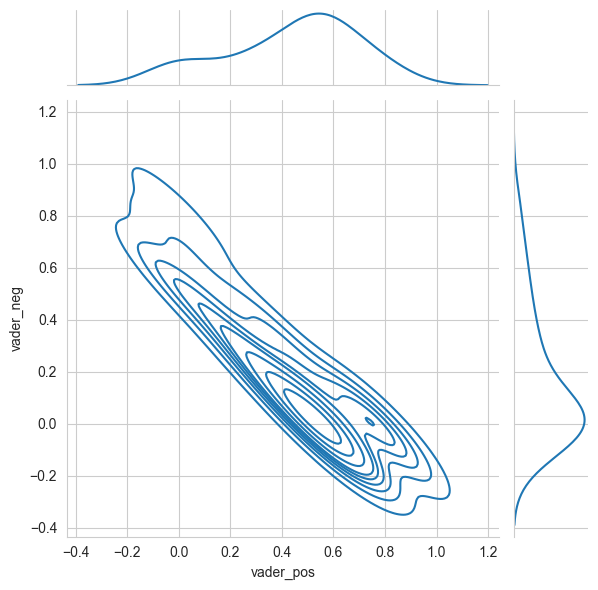

In [181]:
sns.jointplot(data=vaderNeu05, x='vader_pos', y='vader_neg', kind="kde")

In [182]:
df2['date'] = pd.to_datetime(df2['date'])
#df2['vader_neg']=df2['vader_neg']*-1
aggregated_df = df2.groupby(df2['date'].dt.date).agg({
    'vader_comp': 'mean',
    'vader_neg': 'mean',
    'vader_neu':'mean',
    'vader_pos':'mean'
}).reset_index()

# Display the first few rows of the aggregated DataFrame
aggregated_df.head()

,date,vader_comp,vader_neg,vader_neu,vader_pos
0,2022-01-11,0.032173,0.085133,0.811733,0.103133
1,2022-01-12,0.136887,0.051800,0.874000,0.074200
2,2022-01-13,0.120667,0.026733,0.916267,0.057000
3,2022-01-14,0.049967,0.045333,0.904733,0.049933
4,2022-01-19,0.355720,0.005133,0.870333,0.124533


In [183]:
aggregated_df.to_csv('data/2022_tweet_score_final.csv')

In [187]:
# 加载比特币价格数据
btc_price_data = pd.read_csv('data/BTC-USD.csv')
feargreed=pd.read_csv('data/fear_greed_data.csv')
feargreed['date'] = pd.to_datetime(feargreed['timestamp'])  # 确保日期是日期类型
btc_price_data['date'] = pd.to_datetime(btc_price_data['time'])  # 确保日期是日期类型
btc_price_data.rename(columns={'close': 'btc_Price'}, inplace=True)  # 重命名列以明确含义
# 过滤出2022年的数据
btc_price_data = btc_price_data[btc_price_data['date'].apply(lambda x: x.year == 2022)]
# 合并数据
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

combined_data = pd.merge(btc_price_data, aggregated_df, on='date', how='inner')
combined_data=pd.merge(combined_data,feargreed,on='date',how='inner')
combined_data

,time,open,high,low,btc_Price,volume,SMA_20,RSI_14,date,vader_comp,vader_neg,vader_neu,vader_pos,timestamp,fear_greed,value_classification
0,2022/12/27,16919.823027,16963.002980,16631.430000,16706.459710,3.144405e+10,17541.897619,22.526371,2022-12-27,0.075593,0.085533,0.829067,0.085400,2022-12-27,27,Fear
1,2022/12/26,16832.923371,16911.649971,16804.839790,16908.948430,2.654351e+10,17344.542120,38.910766,2022-12-26,-0.017100,0.086333,0.836400,0.077000,2022-12-26,28,Fear
2,2022/12/25,16836.196000,16849.687200,16739.651100,16829.918404,2.198238e+10,17136.839261,40.324214,2022-12-25,0.264927,0.023667,0.818733,0.157600,2022-12-25,29,Fear
3,2022/12/24,16779.530798,16853.542200,16779.530798,16833.882100,2.062695e+10,16982.846892,45.066666,2022-12-24,0.140360,0.000000,0.892467,0.107533,2022-12-24,29,Fear
4,2022/11/21,16286.806400,16286.806400,15598.495100,15779.971702,5.020128e+10,16743.371183,31.344906,2022-11-21,0.158387,0.035600,0.853333,0.111133,2022-11-21,21,Extreme Fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2022/1/19,42373.525700,42472.497065,41204.174810,41676.498777,5.312831e+10,38594.466746,68.521035,2022-01-19,0.355720,0.005133,0.870333,0.124533,2022-01-19,24,Extreme Fear
113,2022/1/14,42549.959000,43387.738252,41808.151156,43068.726580,6.254953e+10,38971.186339,72.722599,2022-01-14,0.049967,0.045333,0.904733,0.049933,2022-01-14,21,Extreme Fear
114,2022/1/13,43888.844000,44290.042287,42334.354690,42580.330300,5.094850e+10,39258.407779,73.318395,2022-01-13,0.120667,0.026733,0.916267,0.057000,2022-01-13,21,Extreme Fear
115,2022/1/12,42710.847500,44168.127900,42470.150041,43900.027000,5.447909e+10,39515.310714,78.667475,2022-01-12,0.136887,0.051800,0.874000,0.074200,2022-01-12,22,Extreme Fear


In [188]:
combined_data.head(50)

,time,open,high,low,btc_Price,volume,SMA_20,RSI_14,date,vader_comp,vader_neg,vader_neu,vader_pos,timestamp,fear_greed,value_classification
0,2022/12/27,16919.823027,16963.002980,16631.430000,16706.459710,3.144405e+10,17541.897619,22.526371,2022-12-27,0.075593,0.085533,0.829067,0.085400,2022-12-27,27,Fear
1,2022/12/26,16832.923371,16911.649971,16804.839790,16908.948430,2.654351e+10,17344.542120,38.910766,2022-12-26,-0.017100,0.086333,0.836400,0.077000,2022-12-26,28,Fear
2,2022/12/25,16836.196000,16849.687200,16739.651100,16829.918404,2.198238e+10,17136.839261,40.324214,2022-12-25,0.264927,0.023667,0.818733,0.157600,2022-12-25,29,Fear
3,2022/12/24,16779.530798,16853.542200,16779.530798,16833.882100,2.062695e+10,16982.846892,45.066666,2022-12-24,0.140360,0.000000,0.892467,0.107533,2022-12-24,29,Fear
4,2022/11/21,16286.806400,16286.806400,15598.495100,15779.971702,5.020128e+10,16743.371183,31.344906,2022-11-21,0.158387,0.035600,0.853333,0.111133,2022-11-21,21,Extreme Fear
5,2022/11/20,16704.480433,16746.273600,16248.149200,16291.447700,2.844598e+10,16702.226538,38.023856,2022-11-20,0.123987,0.074867,0.801000,0.124267,2022-11-20,24,Extreme Fear
6,2022/11/16,16898.235800,16988.241200,16414.320760,16673.507711,5.781817e+10,16626.562824,41.932264,2022-11-16,0.233893,0.030733,0.856333,0.112800,2022-11-16,23,Extreme Fear
7,2022/11/15,16614.287154,17086.691200,16555.151500,16894.926500,6.887235e+10,16623.342346,58.617997,2022-11-15,0.131987,0.029133,0.878600,0.092200,2022-11-15,22,Extreme Fear
8,2022/11/14,16331.352178,17151.974262,15838.319300,16630.637464,6.455433e+10,16598.365952,57.739377,2022-11-14,0.162753,0.037933,0.874200,0.087867,2022-11-14,24,Extreme Fear
9,2022/11/13,16800.992600,16933.574500,16272.735800,16349.997597,3.995228e+10,16570.679651,48.509285,2022-11-13,-0.026580,0.064467,0.870000,0.065467,2022-11-13,22,Extreme Fear


In [189]:
combined_data[['vader_pos', 'vader_neu', 'vader_neg', 'vader_comp']] = combined_data[['vader_pos', 'vader_neu', 'vader_neg', 'vader_comp']].interpolate()

In [190]:
df=combined_data

C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_68976\3278769197.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['btc_price_normalized'] = (df['btc_Price'] - df['btc_Price'].mean()) / df['btc_Price'].std()
C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_68976\3278769197.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score_normalized'] = (df['vader_comp'] - df['vader_comp'].mean()) / df['vader_comp'].std()
C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_68976\3278769197.py:21: Settin

皮尔逊相关系数 (Pandas): -0.0716


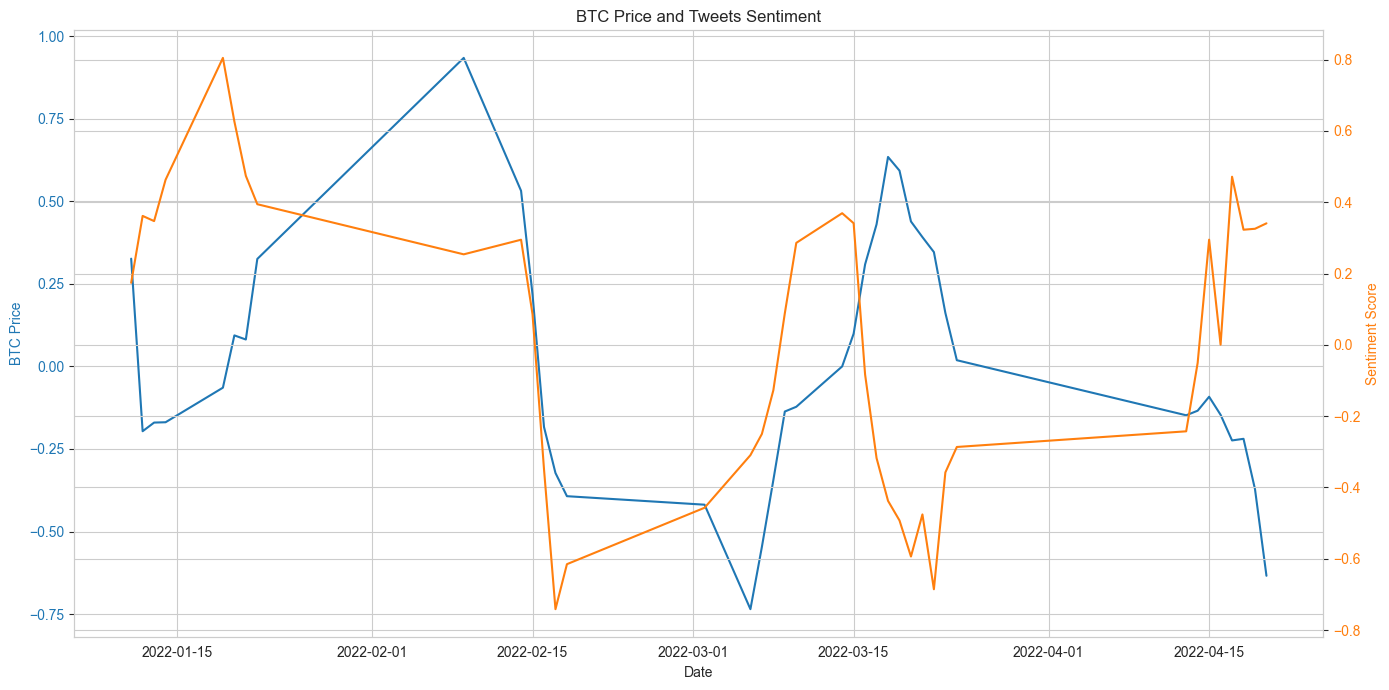

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming df is your DataFrame with 'btc_price' and 'sentiment_score'
# 尝试用第一个格式解析
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# 对未能解析的日期再次尝试用第二个格式解析
df['date'] = df['date'].fillna(pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M", errors='coerce'))

# 只保留年月日部分
df['date'] = df['date'].dt.date
df = df[(df['date'] >= pd.to_datetime('2022-01-01').date()) & (df['date'] <= pd.to_datetime('2022-4-30').date())]

# Normalize both series
df['btc_price_normalized'] = (df['btc_Price'] - df['btc_Price'].mean()) / df['btc_Price'].std()
df['sentiment_score_normalized'] = (df['vader_comp'] - df['vader_comp'].mean()) / df['vader_comp'].std()

# Apply smoothing using a rolling window
df['btc_price_smoothed'] = df['btc_price_normalized'].rolling(window=7).mean()
df['sentiment_score_smoothed'] = df['sentiment_score_normalized'].rolling(window=7).mean()


df_clean=df
# 计算皮尔逊相关系数（仅相关系数）
pearson_corr = df_clean['btc_price_smoothed'].corr(df_clean['sentiment_score_smoothed'])
print(f"皮尔逊相关系数 (Pandas): {pearson_corr:.4f}")





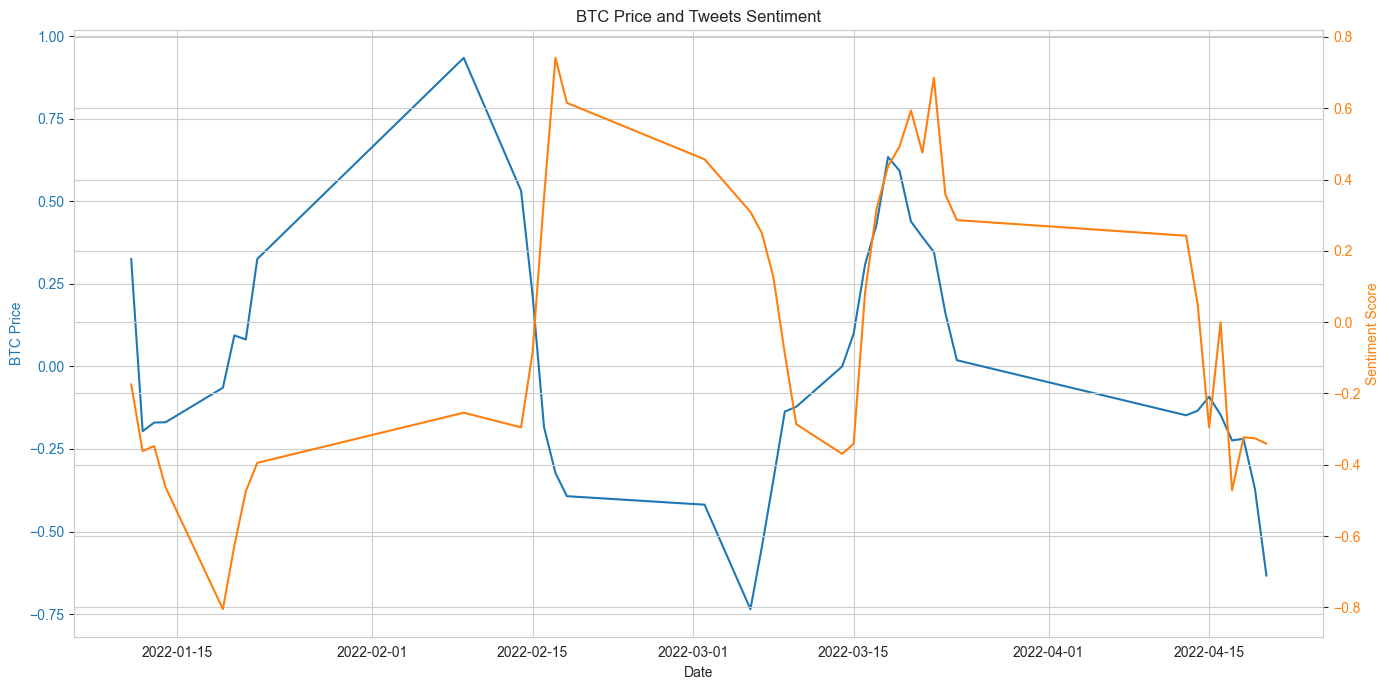

In [201]:
# 绘制归一化后的数据，使用双Y轴
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color=color)
ax1.plot(df_clean['date'], df_clean['btc_price_smoothed'], color=color, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个Y轴，共享X轴
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(df_clean['date'], df_clean['sentiment_score_smoothed'], color=color, label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)

# 添加标题
plt.title('BTC Price and Tweets Sentiment')

# 更好地布局
fig.tight_layout()  

plt.show()

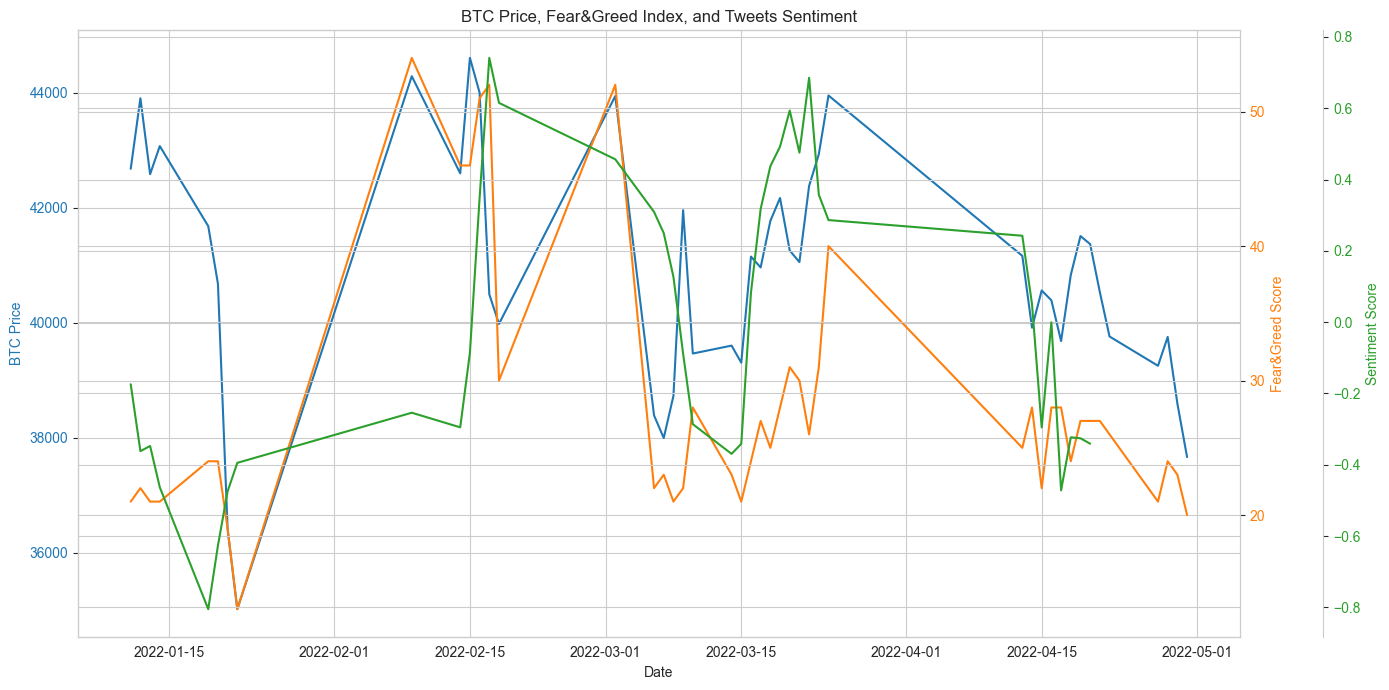

In [203]:
import matplotlib.pyplot as plt

# 创建一个主图和第一个Y轴
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制BTC价格
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color=color)
ax1.plot(df_clean['date'], df_clean['btc_Price'], color=color, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个Y轴，绘制Fear&Greed指数
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Fear&Greed Score', color=color)
ax2.plot(df_clean['date'], df_clean['fear_greed'], color=color, label='Fear&Greed')
ax2.tick_params(axis='y', labelcolor=color)

# 创建第三个Y轴，绘制情绪得分
ax3 = ax1.twinx()  
color = 'tab:green'
# 调整第三个Y轴的位置，使其不与第二个Y轴重叠
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Sentiment Score', color=color)
ax3.plot(df_clean['date'], df_clean['sentiment_score_smoothed']*-1, color=color, label='Sentiment Score')
ax3.tick_params(axis='y', labelcolor=color)

# 添加标题
plt.title('BTC Price, Fear&Greed Index, and Tweets Sentiment')

# 更好地布局
fig.tight_layout() 

In [200]:
# 计算皮尔逊相关系数（仅相关系数）
pearson_corr = df_clean['fear_greed'].corr(df_clean['sentiment_score_smoothed']*-1)
print(f"皮尔逊相关系数 (Pandas): {pearson_corr:.4f}")

皮尔逊相关系数 (Pandas): 0.3615


   Lag  Correlation
0    0     0.077751
1    1     0.017017
2    2    -0.226325
3    3    -0.035434
4    4     0.281650
5    5    -0.082308
6    6     0.048453
7    7     0.237258
8    8    -0.102243
9    9    -0.044762
10  10    -0.009921
11  11    -0.413557
12  12    -0.247717
13  13    -0.039499
14  14     0.160532
15  15     0.196536
16  16     0.150347
17  17    -0.051109
18  18     0.079405
19  19     0.260333
20  20     0.246889
21  21     0.147127
22  22    -0.050950
23  23     0.074112
24  24     0.090344
25  25     0.176230
26  26     0.512256
27  27     0.301720
28  28     0.080290
29  29     0.054935
30  30    -0.067836


C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_68976\655204400.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lagged_correlations = pd.concat([lagged_correlations, pd.DataFrame({'Lag': [lag], 'Correlation': [corr]})], ignore_index=True)


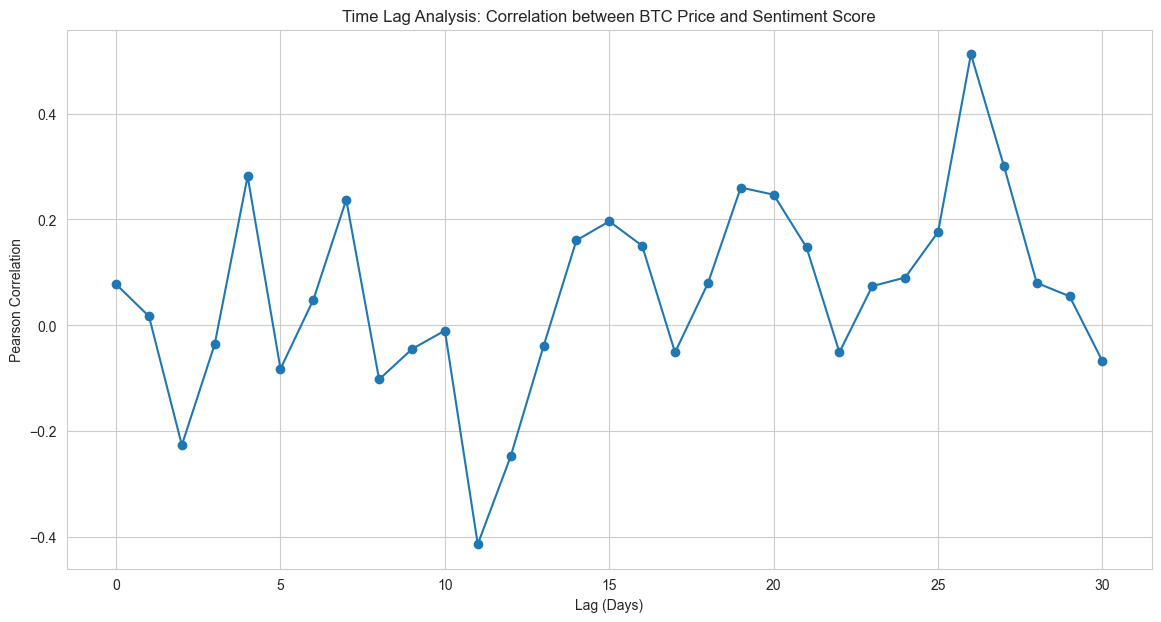

In [157]:
import pandas as pd
import numpy as np

# 设置最大滞后天数
max_lag = 30

# 创建一个DataFrame存储滞后的相关系数
lagged_correlations = pd.DataFrame(columns=['Lag', 'Correlation'])

for lag in range(max_lag + 1):
    # 将比特币价格滞后 'lag' 天
    df_lagged = df_clean.copy()
    df_lagged['btc_Price'] = df_lagged['btc_Price'].shift(lag)
    
    # 删除因滞后产生的NaN值
    df_lagged = df_lagged.dropna(subset=['btc_Price', 'vader_comp'])
    
    # 计算滞后后的皮尔逊相关系数
    corr = df_lagged['btc_Price'].corr(df_lagged['vader_comp'])
    
    # 记录滞后天数和对应的相关系数
    lagged_correlations = pd.concat([lagged_correlations, pd.DataFrame({'Lag': [lag], 'Correlation': [corr]})], ignore_index=True)

# 打印出所有滞后天数的相关系数
print(lagged_correlations)

# 绘制滞后分析结果
plt.figure(figsize=(14, 7))
plt.plot(lagged_correlations['Lag'], lagged_correlations['Correlation'], marker='o')
plt.title('Time Lag Analysis: Correlation between BTC Price and Sentiment Score')
plt.xlabel('Lag (Days)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.show()
